In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import rayleigh
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

SCALE  = 7.35
N      = 10000
N_BINS = 160

# 1 
Generar una muestra aleatoria de $10,000$ puntos de la distribución de $Rayleigh$ utilizando `scale = 7.53`.

In [2]:
def rayleigh_pdf(n_samples, vals, scale=SCALE):
    rx = np.linspace(0, max(vals), n_samples)
    return ((rx /SCALE**2) * np.exp(-rx**2 / (2 * SCALE**2)))

# Datos de entrada (features)
rayleigh_data = np.random.rayleigh(scale=SCALE, size=N)
# Datos reales (labels)
rx = np.linspace(0, max(rayleigh_data), N)
ray_pdf = rayleigh_pdf(N, rayleigh_data) 

rayleigh_data.shape, ray_pdf.shape

((10000,), (10000,))

# 2
Obtén $160$ puntos del histograma de tu muestra.

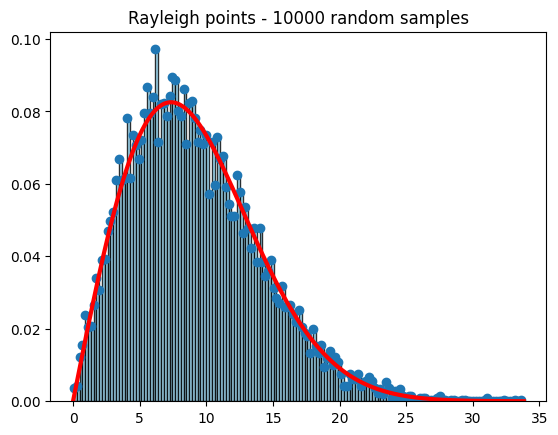

In [3]:
hist, bin_edges = np.histogram(rayleigh_data, bins=N_BINS, density=True)
plt.hist(rayleigh_data, bins=N_BINS, density=True, alpha=0.8, color='skyblue', edgecolor='black')
plt.scatter(bin_edges[:-1], hist)
plt.plot(rx, ray_pdf, 'r', linewidth=3)
plt.title('Rayleigh points - 10000 random samples')
plt.show()

# 3
Divide los puntos en conjunto de entrenamiento y prueba (80-20).

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(bin_edges[:-1], hist, test_size=0.2, random_state=0)
#X_train, X_test = train_test_split(rayleigh_data, test_size=0.2, random_state=0)
#Y_train = rayleigh.pdf(X_train, scale=SCALE)
#Y_test  = rayleigh.pdf(X_test, scale=SCALE)
X_train.shape, Y_train.shape, Y_test.shape, Y_test.shape

((128,), (128,), (32,), (32,))

# 4 
Realiza una regresión polinomial del conjunto de entrenamiento probando distintos grados
de polinomio. Calcula el sesgo y varianza para cada grado utilizado (Es posible que
tengas que dividir tu conjunto de entrenamiento en entrenamiento y validación). Imprime
los resultados en un dataframe de pandas: grado del polinomio, sesgo, varianza, $MAE,
MSE, R2$.

In [5]:
def reshape_data(X, y):
    return X.reshape(-1,1), y.reshape(-1,1)

def to_polynomial(X, deg):
    return PolynomialFeatures(degree=deg).fit_transform(X)

def compute_metrics(x_true_pol, y_true, y_hat):
    mae  = mean_absolute_error(y_true, y_hat)
    mse  = mean_squared_error(y_true, y_hat)
    r2   = r2_score(y_true, y_hat)
    bias = np.mean(((x_true_pol) - np.mean(y_hat))**2)
    var  = np.var(y_hat)
    return mae, mse, r2, bias, var

def create_model_df(max_deg, normalized=False):
    cols = []
    if normalized:
        cols = ['grado_modelo', 'mae', 'mse', 'r2_score', 'sesgo', 'varianza', 'best_alpha']
    else:
        cols = ['grado_modelo', 'mae', 'mse', 'r2_score', 'sesgo', 'varianza']
    df = pd.DataFrame(columns=cols)
    
    model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]) if normalized else LinearRegression()
    
    for deg in range(1, max_deg + 1):
        x_train, y_train = reshape_data(X_train, Y_train)
        x_test, y_test   = reshape_data(X_test, Y_test)
        x_train_pol = to_polynomial(x_train, deg)
        x_test_pol  = to_polynomial(x_test, deg)
        fit = model.fit(x_train_pol, y_train)
        y_hat   = model.predict(x_test_pol)
        
        mae, mse, r2, bias, var = compute_metrics(x_test_pol, y_test, y_hat)
        row = [deg, mae, mse, r2, bias, var, fit.alpha_] if normalized else [deg, mae, mse, r2, bias, var]
        df.loc[len(df.index)] = row
        
    return df

def polynomial_model_linear(max_deg):
    return create_model_df(max_deg)

In [6]:
df = polynomial_model_linear(10)
df

,grado_modelo,mae,mse,r2_score,sesgo,varianza
0,1.0,0.014790,0.000314,0.664061,1.913712e+02,0.000409
1,2.0,0.015154,0.000303,0.675802,7.967653e+04,0.000422
2,3.0,0.007367,0.000071,0.924132,4.372154e+07,0.000920
3,4.0,0.002676,0.000012,0.987151,2.771668e+10,0.000894
4,5.0,0.002566,0.000012,0.987442,1.921392e+13,0.000888
5,6.0,0.002680,0.000012,0.987392,1.415344e+16,0.000922
6,7.0,0.002448,0.000012,0.987003,1.089072e+19,0.000922
7,8.0,0.002501,0.000012,0.986788,8.658064e+21,0.000921
8,9.0,0.002504,0.000012,0.986763,7.058442e+24,0.000922
9,10.0,0.002504,0.000012,0.986990,5.869790e+27,0.000925


# 5
Repite el análisis del punto 4 pero utilizando regularización y validación cruzada.

In [7]:
def polynomial_model_ridgecv(max_deg):
    return create_model_df(max_deg, normalized=True)

In [8]:
df_2 = polynomial_model_ridgecv(10)
df_2

,grado_modelo,mae,mse,r2_score,sesgo,varianza,best_alpha
0,1.0,1.479037e-02,3.144625e-04,6.640437e-01,1.913712e+02,4.088277e-04,1.000
1,2.0,1.515420e-02,3.034622e-04,6.757959e-01,7.967653e+04,4.220095e-04,1.000
2,3.0,7.420638e-03,7.157375e-05,9.235341e-01,4.372154e+07,9.259779e-04,0.001
3,4.0,3.483899e-03,1.949814e-05,9.791691e-01,2.771668e+10,8.128700e-04,0.100
4,5.0,3.165328e-02,1.437011e-03,-5.352319e-01,1.921392e+13,3.832963e-03,0.100
5,6.0,1.722608e+03,4.271330e+06,-4.563279e+09,1.415345e+16,4.152532e+06,0.100
6,7.0,8.270635e+06,1.006057e+14,-1.074822e+17,1.088814e+19,9.646046e+13,0.010
7,8.0,1.137777e+09,1.908370e+18,-2.038809e+21,8.668640e+21,1.800564e+18,0.100
8,9.0,6.508906e+11,6.113472e+23,-6.531333e+26,6.928820e+24,5.663637e+23,0.100
9,10.0,2.530340e+14,9.105958e+28,-9.728358e+31,1.229923e+28,8.264054e+28,0.100


# 6
Presenta tu mejor modelo polinomial y argumenta por qué es el mejor.

Consideraremos el mejor modelo basándonos primero en la métrica $R^2$. Dado que, para grados altos los datos comienzan a tener 
una dimensionalidad mayor, las métricas $MAE$ y $MSE$ nos dan valores poco representativos del verdadero error que el modelo presenta, mientras que la métrica elegida presenta información más útil y adecuada para evaluar un modelo polinomial. 

Podremos extraer el mejor modelo de ambos dataframes (modelos no regularizados y regularizados usando `RidgeCV`) buscando el máximo para la métrica `r2_score` y compararemos los mejores obtenidos entre ellos mismos para conocer el mejor. Sin embargo, esto no es suficiente para decidirnos entre estos dos; recordemos que buscamos un balance entre varianza y sesgo, por lo que elegiremos el modelo que tenga ambas métricas lo más balanceadas posible.

In [9]:
best_nonreg = df.iloc[df['r2_score'].argmax()]
best_reg    = df_2.iloc[df_2['r2_score'].argmax()]
best_models = pd.DataFrame([best_nonreg, best_reg], columns=df.columns)
best_models.insert(0, "categoria", ['non_reg', 'reg'])
best_models

,categoria,grado_modelo,mae,mse,r2_score,sesgo,varianza
4,non_reg,5.0,0.002566,0.000012,0.987442,1.921392e+13,0.000888
3,reg,4.0,0.003484,0.000019,0.979169,2.771668e+10,0.000813


Observamos que el modelo regularizado posee una vairanza y un sesgo mucho menor a los presentados por el modelo no regularizado, además de un valor de $R^2$ aceptable. Auque el modelo no regularizado presenta una puntuación perfecta, este posee valores muy altos en cuanto a sesgo y varianza, por lo que decidiremos utilizar el modelo regularizado.

In [10]:
def build_model(model_deg):
    x_train, y_train = reshape_data(X_train, Y_train)
    x_test, y_test   = reshape_data(X_test, Y_test)
    x_train_pol      = to_polynomial(x_train, model_deg)
    x_test_pol       = to_polynomial(x_test, model_deg)
    model = Ridge(alpha=best_reg['best_alpha']).fit(x_train_pol, y_train)
    print("mae: {}, mse: {}, r2_score: {}, sesgo: {}, varianza: {}"
          .format(*compute_metrics(x_test_pol, y_test, model.predict(x_test_pol))))
    return model

best_deg = int(best_models.iloc[0]['grado_modelo'])
best_model = build_model(best_deg)

mae: 0.002576132087283972, mse: 1.1806138866503739e-05, r2_score: 0.9873869022289158, sesgo: 19213919785630.625, varianza: 0.0008876008407143655


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.76441e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


# 7
Utiliza la distribución de Rayleigh utilizando el estimador máximo verosímil: `scale = MLE` y compáralo con el modelo polinomial presentado en el punto 6, probando su rendimiento el el conjunto de prueba.

MAE: 0.03752435079506864,
MSE: 0.0021207938485390985,
R2: -1.3284586928759143,
Bias: 19213919785630.625,
Var: 0.0008876008407143655


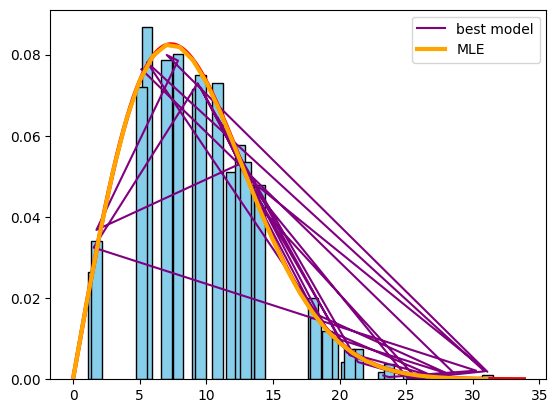

In [13]:
X = np.concatenate([X_train, X_test])
Y = np.concatenate([Y_train, Y_test])
x_test, y_test = reshape_data(X_test, Y_test)
MLE = np.sqrt((np.sum(x_test**2)) / (2 * len(x_test)))

y_mle  = rayleigh_pdf(len(x_test), x_test, MLE)
x_test = to_polynomial(x_test, best_deg)
y_hat  = best_model.predict(x_test)

mae, mse, r2, bias, var = compute_metrics(x_test, y_mle, y_hat)

print(f"MAE: {mae},\nMSE: {mse},\nR2: {r2},\nBias: {bias},\nVar: {var}")
plt.bar(X_test, Y_test, color='skyblue', edgecolor='black')
plt.plot(rx, ray_pdf, 'r', linewidth=3)
plt.plot(X_test, y_hat, label='best model', c='purple')
plt.plot(y_mle, label='MLE', c='orange', linewidth=3)
plt.legend()
plt.show()